SARIMA

Код взят отсюда: https://github.com/marcopeix/time-series-analysis/blob/master/Advanced%20modelling/SARIMA.ipynb

In [1]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [35]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Work/model.csv')

In [3]:
df.columns

Index(['Unnamed: 0', 'year', 'month', 'day', 'heigh', 'rainy', 'date', 'week',
       'heigh_9403', 'rainy_9403', 'heigh_9404', 'rainy_9404', 'heigh_9405',
       'rainy_9405', 'heigh_9406', 'rainy_9406', 'heigh_9408', 'rainy_9408',
       'heigh_9410', 'rainy_9410', 'heigh_9413', 'rainy_9413', 'heigh_9416',
       'rainy_9416', 'heigh_9417', 'rainy_9417', 'heigh_9419', 'rainy_9419',
       'heigh_9420', 'rainy_9420', 'heigh_9422', 'rainy_9422', 'heigh_9518',
       'rainy_9518'],
      dtype='object')

In [36]:
data = df[['date', 'heigh']]

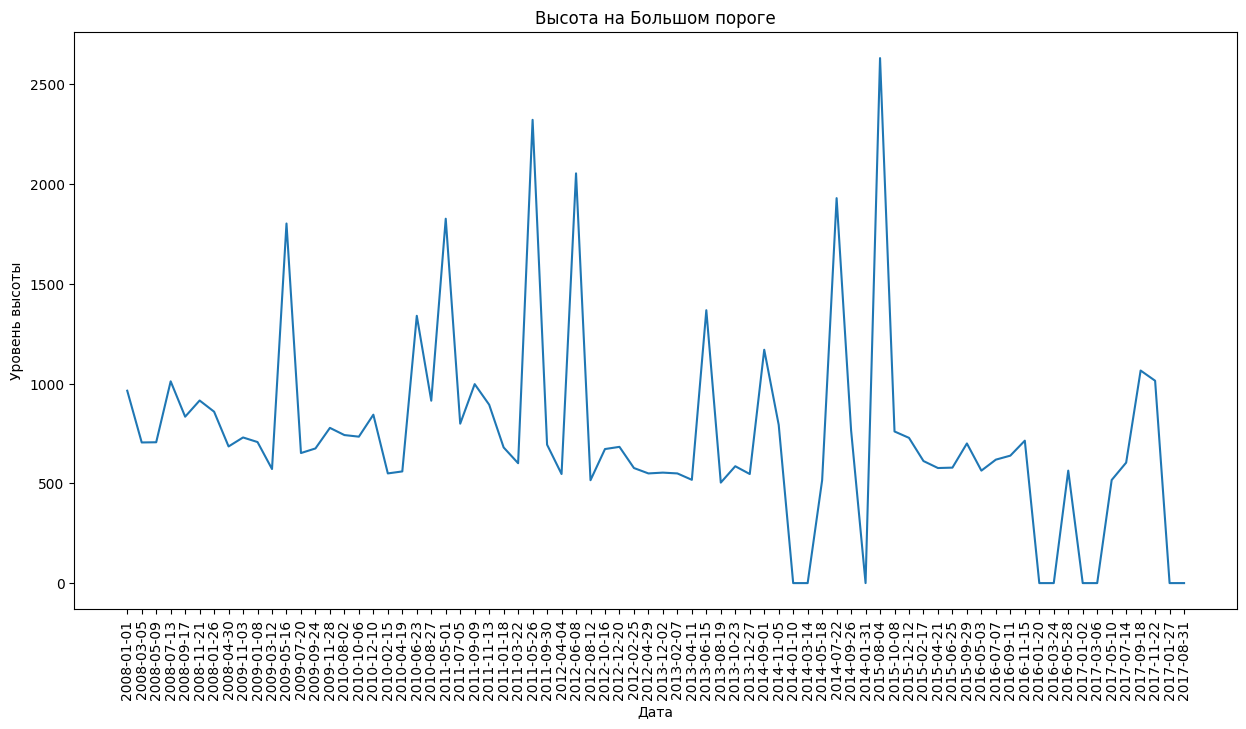

In [37]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['date'][::50], data['heigh'][::50])
plt.title('Высота на Большом пороге')
plt.ylabel('Уровень высоты')
plt.xlabel('Дата')
plt.xticks(rotation=90)
#plt.grid(True)
plt.show()

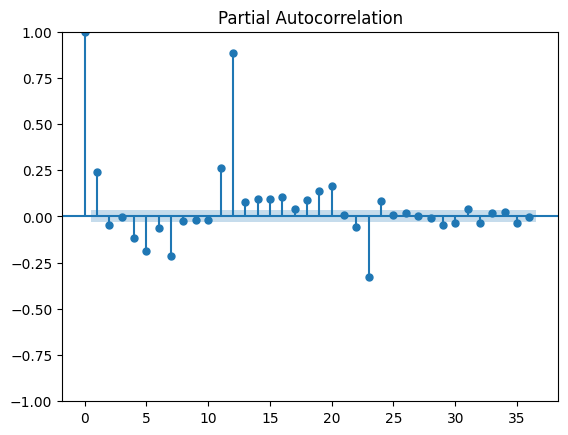

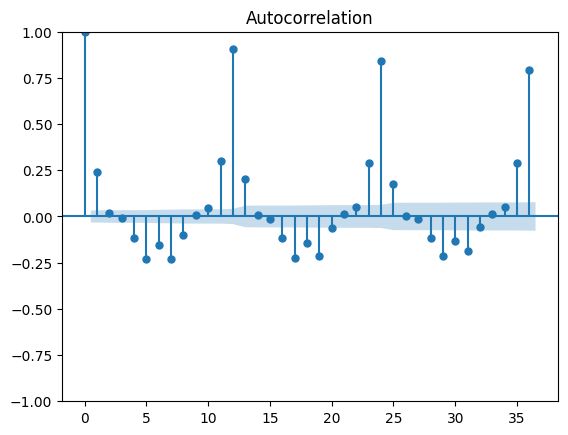

In [38]:
plot_pacf(data['heigh']);
plot_acf(data['heigh']);

In [39]:
ad_fuller_result = adfuller(data['heigh'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.5977677771322685
p-value: 0.09345950073110948


In [40]:
data['heigh'] = np.log(data['heigh'])
data['heigh'] = data['heigh'].diff()
data = data.drop(data.index[0])

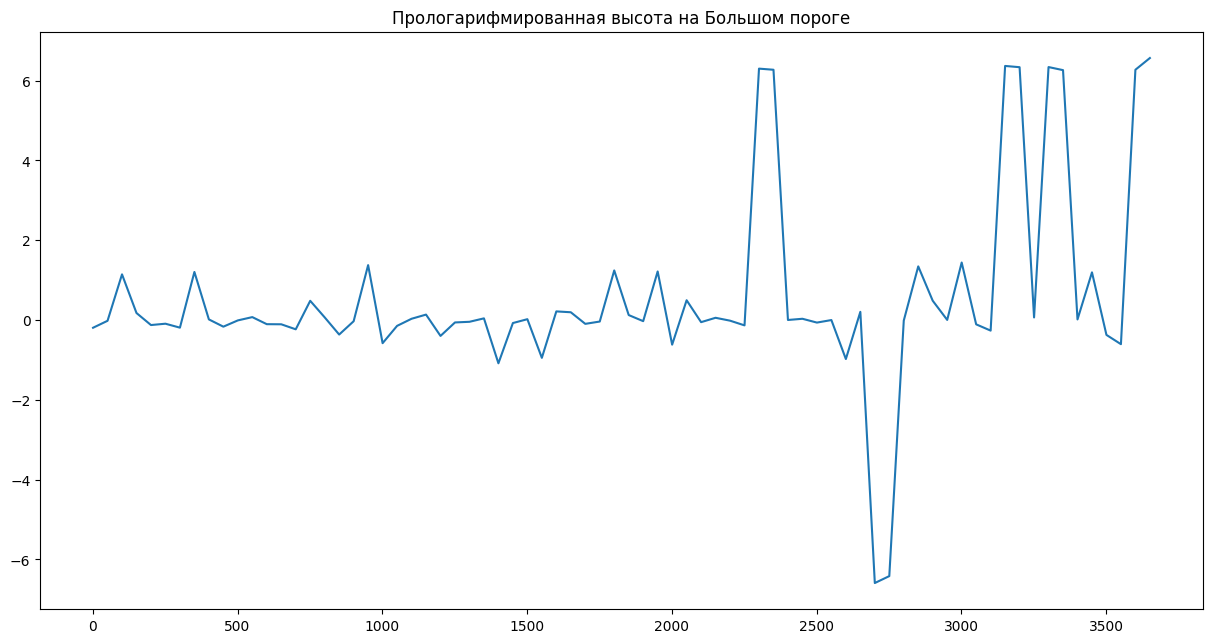

In [41]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['heigh'][::50])
plt.title("Прологарифмированная высота на Большом пороге")
plt.show()

In [43]:
data['heigh'] = data['heigh'].diff(4)
data = data.drop([1, 2, 3, 4], axis=0).reset_index(drop=True)
data.head()

,date,heigh
0,2008-06-01,1.374763
1,2008-07-01,-0.523441
2,2008-08-01,-0.079101
3,2008-09-01,0.037450
4,2008-10-01,-1.473043


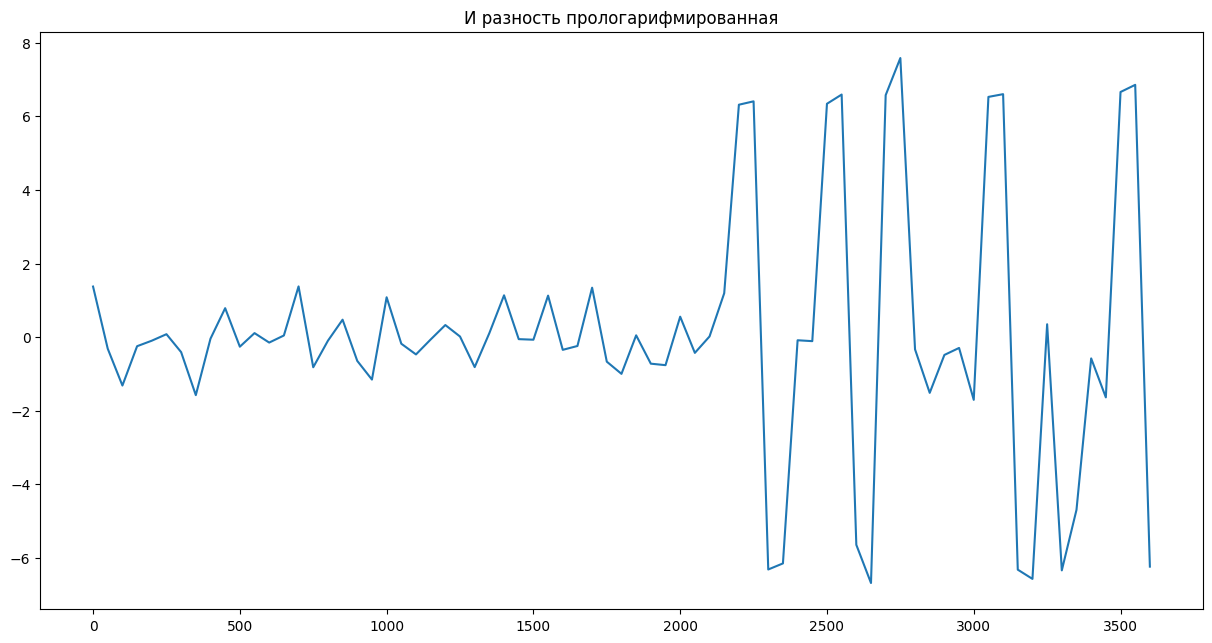

In [44]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['heigh'][::50])
plt.title("И разность прологарифмированная")
plt.show()

In [45]:
ad_fuller_result = adfuller(data['heigh'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -23.62255359162141
p-value: 0.0


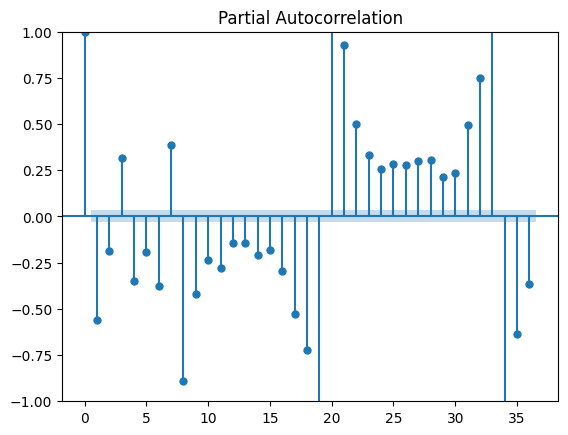

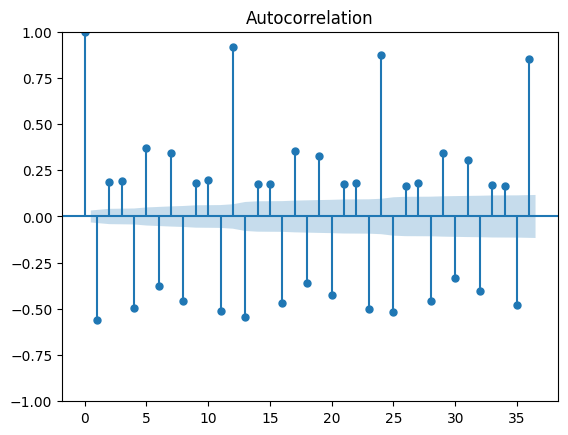

In [46]:
plot_pacf(data['heigh']);
plot_acf(data['heigh']);

Какая-то ерунда получилась.

In [17]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [27]:
p = range(0, 3, 1)
d = 2
q = range(0, 3, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

144


In [28]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 4, data['heigh'])
result_df

  0%|          | 0/144 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(1, 1, 3, 3)",18.000000
1,"(0, 2, 2, 3)",8044.344575
2,"(0, 2, 3, 1)",8109.018939
3,"(1, 2, 2, 3)",8110.824550
4,"(1, 2, 3, 1)",8123.961709
...,...,...
138,"(0, 0, 0, 1)",23343.860359
139,"(1, 0, 0, 0)",24414.322656
140,"(0, 0, 0, 2)",24499.167312
141,"(0, 0, 1, 0)",26205.649452


Пыхтела 1ч40мин(когда их было 265)

In [29]:
best_model = SARIMAX(data['heigh'], order=(1, 2, 1), seasonal_order=(3, 1, 3, 4)).fit(dis=-1)
print(best_model.summary())

                                         SARIMAX Results                                         
Dep. Variable:                                     heigh   No. Observations:                 3648
Model:             SARIMAX(1, 2, 1)x(3, 1, [1, 2, 3], 4)   Log Likelihood               -6031.717
Date:                                   Thu, 01 Jun 2023   AIC                          12081.434
Time:                                           17:17:09   BIC                          12137.236
Sample:                                                0   HQIC                         12101.309
                                                  - 3648                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6595      0.004   -149.084      0.000    

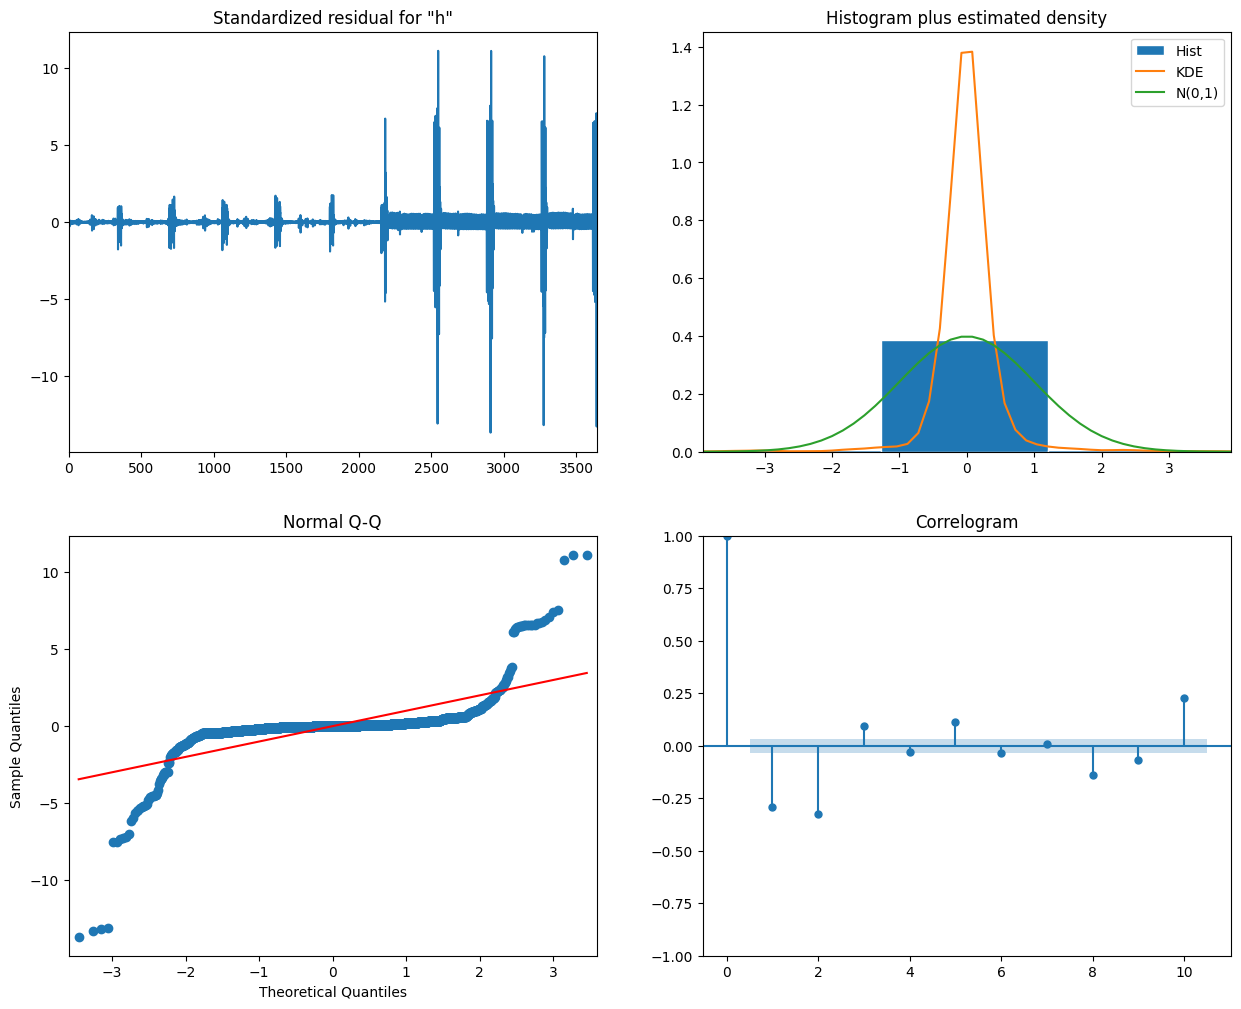

In [47]:
best_model.plot_diagnostics(figsize=(15,12));

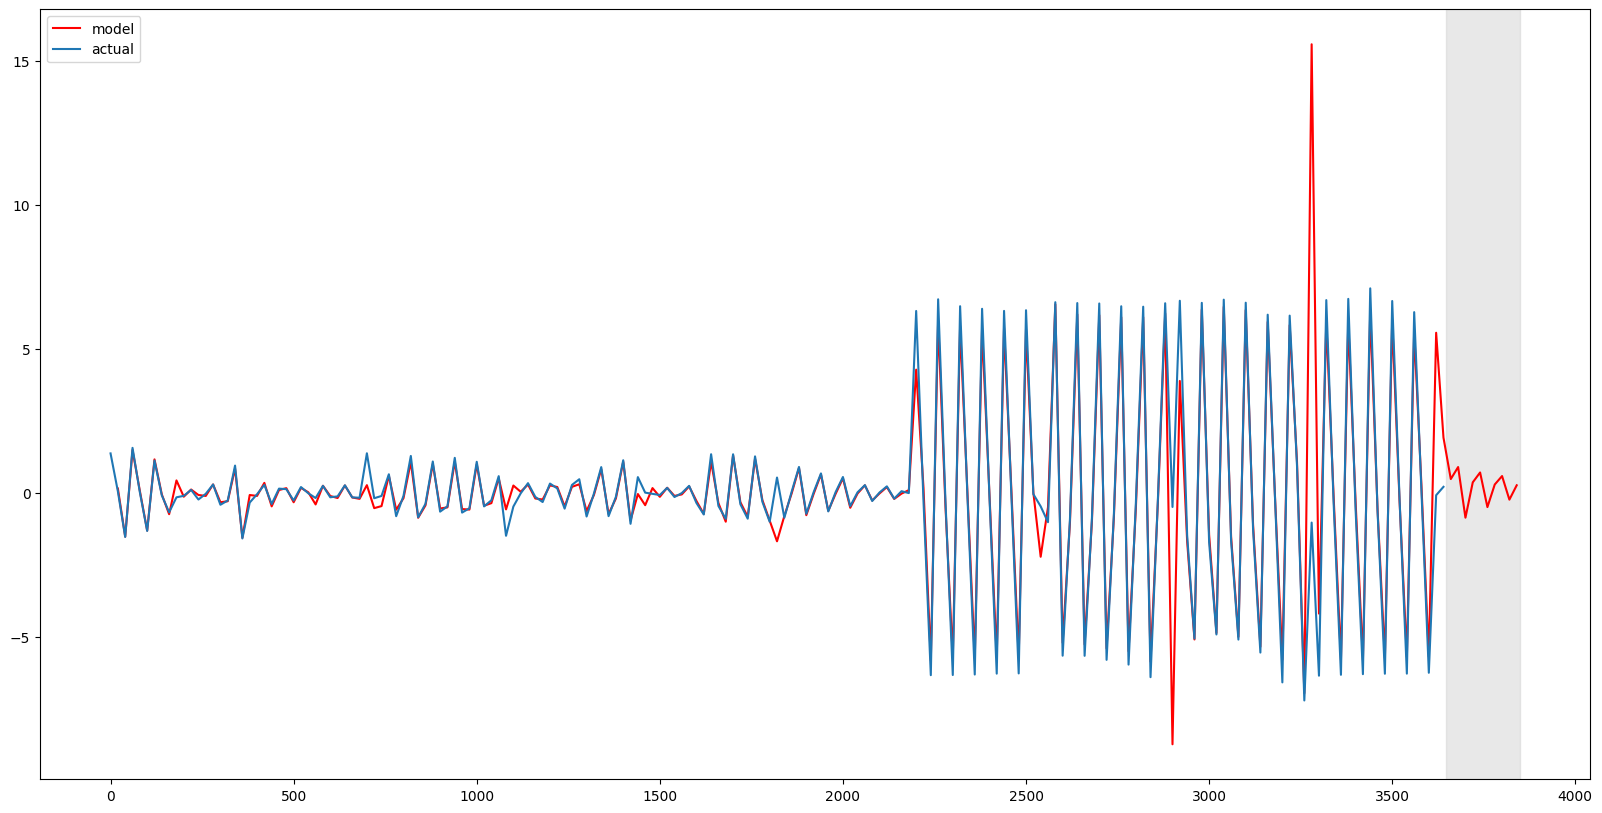

In [54]:
data['arima_model'] = best_model.fittedvalues
data['arima_model'][:4+1] = np.NaN

forecast = best_model.predict(start=data.shape[0], end=data.shape[0] + 200)
forecast = data['arima_model'].append(forecast)

plt.figure(figsize=(20, 10))
plt.plot(forecast[::20], color='r', label='model')
plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(data['heigh'][::20], label='actual')
plt.legend()

plt.show()